In [135]:
import os
import pickle
os.getcwd()

'/Users/gimpuleumoe/Documents/TUM2020S/2020-pooreumoe-msc-thesis/code/CP_dec'

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac
import pickle
# import some useful functions (they are available in utils.py)
# from utils import *

In [137]:
from tensorly.decomposition import candecomp_parafac

In [138]:
# Load Tensor
with open('../pkl/global_weekly_sorted_tensor2.pkl', 'rb') as f:
    travel_tensor_raw = pickle.load(f)

In [98]:
# adj_list = []
# country_cutline = 30
# interval = 50 # 26 * 4 weeks = 2 year,
# for i in range(interval):
#     ajm = np.sum(travel_tensor_raw[4*i:4 + 4*i][:,0:country_cutline,0:2*country_cutline], axis=0)
#     adj_list.append(ajm)
# travel_data = np.array(adj_list)

In [139]:
travel_data =travel_tensor_raw

In [140]:
travel_data.shape

(200, 226, 452)

In [141]:
# Create serial tensors by slicing the time interval.
W = 1 # window size
serial_tensors = []
for i in range(len(travel_data)-W+1):
    serial_tensors.append(travel_data[i:i+1])
serial_tensors = np.array(serial_tensors)

In [142]:
serial_tensors.shape

(200, 1, 226, 452)

In [143]:
rank = 30
# A = np.random.random((serial_tensors[0].shape[1], rank)) #node
# B = np.random.random((serial_tensors[0].shape[2], rank)) #feature
# C = np.random.random((serial_tensors[0].shape[0], rank)) #time
init_ABC = candecomp_parafac.initialize_factors(travel_data, rank=rank)
A = init_ABC[1]
B = init_ABC[2]
C = np.array([init_ABC[0][0]])

A_array = []
C_array = []
Ct_B =0
B_At =0
alpha = 0.05
beta = 0.05
T_interval = len(serial_tensors)

for t in range(T_interval):
    Xt = serial_tensors[t]
    
  # optimiza A
    Ct_B = khatri_rao([C, B])
    Xt_mode1_transpose = tl.unfold(Xt, mode=1).T
    X = np.concatenate((Xt_mode1_transpose, np.sqrt(alpha)*A.T), axis=0)
    I = np.identity(A.shape[1])
    F = np.concatenate((Ct_B, np.sqrt(alpha)*I), axis=0)
    A = np.linalg.lstsq(F,X, rcond=None)[0].T
    A_array.append(A)

    # optimize C
    B_At = khatri_rao([B, A])
    Xt_mode3_transpose = tl.unfold(Xt, mode=0).T
    X = np.concatenate((Xt_mode3_transpose, np.sqrt(beta)*C.T), axis=0)
    I = np.identity(C.shape[1])
    F = np.concatenate((B_At, np.sqrt(beta)*I), axis=0)
    C = np.linalg.lstsq(F,X, rcond=None)[0].T
    C_array.append(C)

    if t % int(T_interval * .1) == 0:
        res_a = np.square(Ct_B.dot(A.T) - Xt_mode1_transpose)
        res_c = np.square(B_At.dot(C.T) - Xt_mode3_transpose)
        print("interation:", t, "| Loss (A):", res_a.mean(), "| Loss (C):", res_c.mean())

interation: 0 | Loss (A): 0.007924980617706098 | Loss (C): 0.007394806731959755
interation: 20 | Loss (A): 0.012529287398174 | Loss (C): 0.01379765773710868
interation: 40 | Loss (A): 0.016059579811574857 | Loss (C): 0.019890711299320067
interation: 60 | Loss (A): 0.018165547136025743 | Loss (C): 0.02101563434021526
interation: 80 | Loss (A): 0.033073616630229855 | Loss (C): 0.04085328988163614
interation: 100 | Loss (A): 0.028024654616407817 | Loss (C): 0.0319067278825739
interation: 120 | Loss (A): 0.03323920099290556 | Loss (C): 0.04608806507451955
interation: 140 | Loss (A): 0.05939614481080708 | Loss (C): 0.08253978209278659
interation: 160 | Loss (A): 0.0497171342594762 | Loss (C): 0.06323239318272485
interation: 180 | Loss (A): 0.007886634490994363 | Loss (C): 0.008186422479351028


In [144]:
np.array(C_array).shape

(200, 1, 30)

In [145]:
# optimize B
# X = np.concatenate(, axis=0)
X_concat = tl.unfold(serial_tensors[0], mode=2).T
for x in range(len(serial_tensors)):
    if x>0:
        XtT_unfold = tl.unfold(serial_tensors[x], mode=2).T
        X_concat = np.concatenate((X_concat, XtT_unfold))

F_concat = khatri_rao([C_array[0], A_array[0]])
for i in range(len(C_array)):
    if i >0:
        F_concat = np.concatenate((F_concat, khatri_rao([C_array[i], A_array[i]])))
        
B = np.linalg.lstsq(F_concat,X_concat, rcond=None)[0].T

In [146]:
# Error comparision 

res_b_array=[]
res_rand_b_array=[]
for i in range(len(serial_tensors)):
    Xt = serial_tensors[i]
    Xt_mode2_transpose = tl.unfold(Xt, mode=2).T
    res_b = np.square(khatri_rao([A,C]).dot(B.T) - Xt_mode2_transpose)
    res_b_array.append(res_b.mean())
    rB = np.random.random((serial_tensors[0].shape[2], rank))
    rand_res_b = np.square(khatri_rao([A,C]).dot(rB.T) - Xt_mode2_transpose)
    res_rand_b_array.append(rand_res_b.mean())
#     print(res_b.mean(), rand_res_b.mean())

res_a = np.square(khatri_rao([C, B]).dot(A.T) - Xt_mode1_transpose)

res_c = np.square(khatri_rao([B, A]).dot(C.T) - Xt_mode3_transpose)
print(np.mean(res_b_array[10:]), np.mean(res_rand_b_array[10:]))
print(res_a.mean(), np.mean(res_b_array[10:]), res_c.mean())

0.03751147596239469 0.043850754240501263
0.0006867507596494626 0.03751147596239469 0.0008744318669650523


In [147]:
np.array(A_array).shape

(200, 226, 30)

In [148]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
# save_object(home_adj_list, '../pkl/[weekly]home_adj_from20180107_2.pkl')

In [149]:
# save_object(A_array, '../pkl/COVID_Aopt.pkl')
# save_object(C_array, '../pkl/COVID_Copt.pkl')
# save_object(B, '../pkl/COVID_Bopt.pkl')

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

In [151]:
Aopt_array = A_array
Copt_array = C_array
Bstar = B
np.array(Aopt_array).shape # time x nodes # rank (21 54 19)
print(Bstar.shape) # Fature x rank
np.array(Copt_array).shape # time x 1 x rank

(452, 30)


(200, 1, 30)

In [161]:
week_slices = pd.date_range('2016-01-04', periods=200+1, freq='W')

In [162]:
# week_slices = week_slices[0::4]

In [163]:
xaxis = week_slices[1:]

In [164]:
with open('../pkl/new_country_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [165]:
with open('../pkl/Twitter_label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f) 

In [166]:
countries = label_dict

In [167]:
label_dict

{'0': 'US',
 '1': 'GB',
 '2': 'FR',
 '3': 'ES',
 '4': 'IT',
 '5': 'DE',
 '6': 'MX',
 '7': 'CA',
 '8': 'JP',
 '9': 'NL',
 '10': 'BR',
 '11': 'TH',
 '12': 'ID',
 '13': 'MY',
 '14': 'SG',
 '15': 'BE',
 '16': 'AE',
 '17': 'AU',
 '18': 'CH',
 '19': 'PH',
 '20': 'IE',
 '21': 'PT',
 '22': 'AR',
 '23': 'TR',
 '24': 'RU',
 '25': 'KW',
 '26': 'CN',
 '27': 'IN',
 '28': 'HK',
 '29': 'AT',
 '30': 'GR',
 '31': 'KR',
 '32': 'SA',
 '33': 'CO',
 '34': 'SE',
 '35': 'ZA',
 '36': 'TW',
 '37': 'CZ',
 '38': 'DK',
 '39': 'CL',
 '40': 'NO',
 '41': 'PE',
 '42': 'PL',
 '43': 'NZ',
 '44': 'EG',
 '45': 'VN',
 '46': 'QA',
 '47': 'HU',
 '48': 'DO',
 '49': 'MA',
 '50': 'IS',
 '51': 'FI',
 '52': 'HR',
 '53': 'CR',
 '54': 'BH',
 '55': 'LU',
 '56': 'BS',
 '57': 'IL',
 '58': 'UY',
 '59': 'CU',
 '60': 'VE',
 '61': 'UA',
 '62': 'JM',
 '63': 'VA',
 '64': 'EC',
 '65': 'PA',
 '66': 'CY',
 '67': 'NG',
 '68': 'JO',
 '69': 'PY',
 '70': 'RS',
 '71': 'RO',
 '72': 'LK',
 '73': 'CD',
 '74': 'KE',
 '75': 'BG',
 '76': 'MC',
 '77': 'K

In [168]:
LOF_by_countries = []
for i in range(Aopt_array[0].shape[0]):
#     X = np.array(np.exp(Aopt_array))[:,i,:]
    X = np.array(Aopt_array)[:,i,:]
    clf = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
    clf.fit(X)
    neg_scores = clf.negative_outlier_factor_
#     lof_scores = (np.max(neg_scores) - neg_scores)/(np.max(neg_scores) - np.min(neg_scores))
    lof_scores = neg_scores * -1
    LOF_by_countries.append(lof_scores)
    

[ 8.  9.  4.  5.  1.  5.  6.  0.  2. 11.  2. 11.  7.  5.  5.  8.  5. 10.
  2.  5. 12.  4. 11.  3.  7. 16.  8.  6. 24. 17. 18.  8. 11. 16.  9. 22.
 11.  4. 16.  8. 18.  9. 12.  4. 17.  3. 10. 12.  3. 15.  8.  8. 16. 13.
 20.  9.  7.  8. 18. 10. 13. 20. 17. 21. 21. 14. 18. 17. 19. 12. 24. 14.
  8.  7.  6. 32. 18. 14. 19. 17. 13.  8. 22. 20. 20. 26. 21. 13. 13. 12.
 20. 11.  8. 10. 13. 13. 13.  5.  3. 15.  9. 11. 10.  8. 14. 28. 22. 14.
 19. 13. 15. 12. 10. 18.  7. 25. 23. 22. 22. 42. 30. 39. 20. 22. 15. 17.
 34. 20. 21. 35. 29. 25. 25. 32. 41. 27. 14. 25. 36. 43. 30. 43. 34. 34.
 37. 29. 30. 31. 32. 26. 26. 31. 30. 50. 52. 62. 31. 26. 18. 19. 22. 14.
 35. 34. 13. 11. 12. 41. 21. 20. 23. 12. 10. 16. 12. 10.  3.  5.  7.  3.
  9.  6.  0.  6. 12.  6. 13.  5.  9.  9.  2.  8.  2.  6.  5.  2.  6.  6.
  0.  1.]


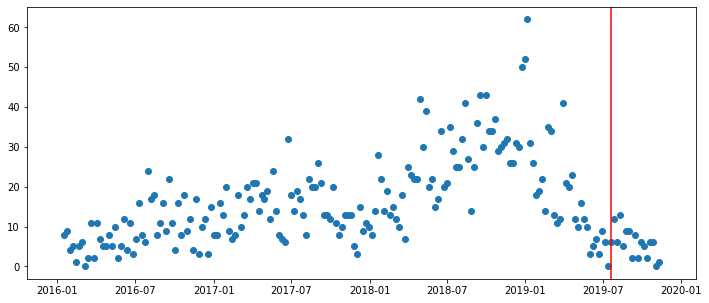

In [169]:
# travel_data.shape
tensors = travel_data[:,:,:54]

cnt_num = 4
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
print(intraffic)

plt.figure(figsize=(12,5))
plt.scatter(xaxis, intraffic)
plt.axvline(x=xaxis[-17], linestyle='-', color='red', label="Massive spread")
# plt.title(str(label_dict[cnt_num])+ " intraffic")

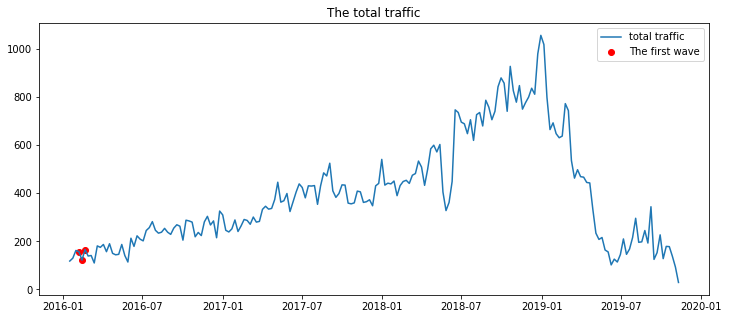

In [170]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape
xaxis = week_slices[1:]

traffic = np.sum(np.sum(tensors, 1),1) #in-traffic
plt.figure(figsize=(12,5))
plt.plot(xaxis, traffic, label= 'total traffic')
plt.scatter(xaxis[3:6], traffic[3:6], color='red', label = 'The first wave')
plt.title("The total traffic")
plt.legend()

In [171]:
from datetime import datetime  
from datetime import timedelta  

[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  3.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  6.  0.  2.  1.  1.  0.  0.
  1.  0.  1.  5.  1.  5.  2.  2.  0.  0.  1.  1.  1.  2.  2.  0.  0.  1.
  0.  0.  1.  3.  0.  0.  0.  0.  1.  1.  4.  6.  0.  1.  0.  0.  0.  2.
  2.  0.  2.  4.  2.  2.  0.  1.  2.  3.  5.  0.  1.  9.  2.  1.  2.  3.
  0.  4.  1.  5.  4.  2.  3.  0.  0.  2.  2.  0.  0.  3.  3.  0.  0.  0.
  2.  1.  2.  2.  2.  1.  0.  2.  4.  7.  0.  7.  2.  0.  0.  0.  2.  2.
  4. 10.  3.  6.  5.  1.  4.  1.  3.  4.  2.  2.  8.  4.  0.  5.  6.  7.
  6.  5.  3. 12.  5.  1.  1.  1.  4.  3.  6.  1.  1.  0.  2.  0.  2.  2.
  6.  4.  3.  1.  0.  0.  0.  3.  0.  0.  2.  1.  4.  0.  1.  0.  2.  0.
  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  1.  1.
  7.  0.]


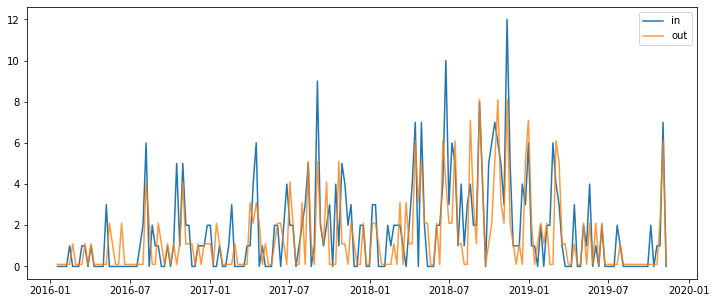

In [172]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape

cnt_num = 47
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
outtraffic = np.sum(tensors[:,cnt_num,:], 1) #outtraffic
print(intraffic)

plt.figure(figsize=(12,5))
plt.plot(xaxis, intraffic, label= 'in')
plt.plot(xaxis, outtraffic+0.1, label='out', alpha=0.8)
# plt.fill_between([xaxis[-19] + timedelta(days=1.5),xaxis[-17]], 0, 23, color='magenta', alpha=0.15, label = 'Surge in carriers mobility: 23.Feb ~ 29.Feb')
# plt.title(str(label_dict[cnt_num])+ " traffic")
plt.legend()

In [173]:
tensors.shape

(200, 226, 54)

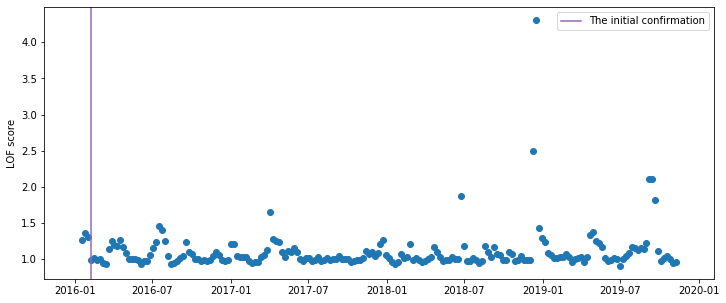

In [174]:
plt.figure(figsize=(12,5))
cnt_num = 24
plt.scatter(xaxis,LOF_by_countries[cnt_num])
plt.axvline(xaxis[3], color='tab:purple', label="The initial confirmation")
plt.legend()
plt.ylabel('LOF score')
# plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[cnt_num]))
plt.show()
# plt.title('LOF score of ' + countries[18])

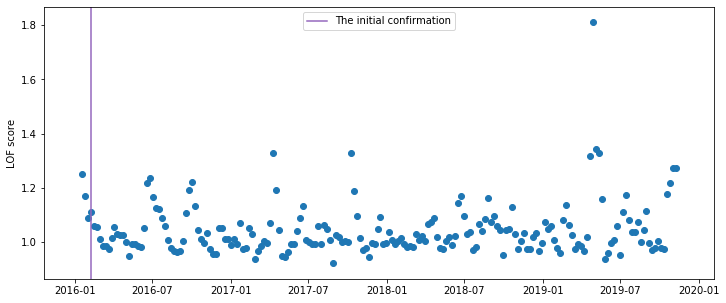

In [178]:
plt.figure(figsize=(12,5))
cnt_num = 2
plt.scatter(xaxis,LOF_by_countries[cnt_num])
plt.axvline(xaxis[3], color='tab:purple', label="The initial confirmation")
plt.legend()
plt.ylabel('LOF score')
# plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[cnt_num]))
plt.show()
# plt.title('LOF score of ' + countries[18])

In [175]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape

cnt_num = 3
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
print(intraffic)

# plt.figure(figsize=(12,5))
# plt.scatter(xaxis, intraffic)
# plt.title(str(label_dict[cnt_num])+ " intraffic")

[ 0.  5.  4.  4.  0.  2. 18.  2.  3.  7. 10. 20. 13. 11. 11.  8.  4.  2.
  1.  5. 10.  2. 11. 23. 12. 15. 23. 15. 10. 13. 16. 14. 11.  8. 14. 12.
 31. 16. 22.  7.  8. 17.  5. 15. 10. 19.  8. 10.  4.  7. 24. 24. 13.  5.
 12.  7. 11.  7.  8. 11. 20.  7.  8. 12. 25. 19. 11. 21. 20. 25. 20. 32.
 18. 16. 28. 34. 25. 24. 25. 22. 26. 22. 18. 46. 36. 34. 17. 26. 22. 40.
 21. 14. 20. 16.  9. 17. 14. 31. 24. 15. 19. 20. 14.  9. 16. 17. 17. 13.
 29. 25. 14. 16. 18. 14. 25. 22. 33. 26. 39. 30. 20. 59. 20. 21. 21. 17.
 45. 35. 57. 36. 59. 48. 40. 42. 66. 34. 43. 53. 45. 38. 52. 43. 45. 19.
 48. 25. 40. 27. 30. 41. 30. 30. 51. 20. 29. 38. 18. 27. 29. 21. 28. 33.
 34. 41. 41. 19. 19. 12. 28. 11. 18. 15. 14. 17. 16. 13. 11.  8.  9.  3.
  9.  9.  5. 19. 18.  6. 18. 10.  9. 16.  8.  6.  7.  3.  0.  3.  7.  1.
  4.  0.]


In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(xaxis,LOF_by_countries[3])
plt.axvline(xaxis[6], color='tab:purple', label="The initial confirmation")
plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[3]))
plt.show()
# plt.title('LOF score of ' + countries[18])

In [34]:
xaxis[-6]

Timestamp('2020-05-17 00:00:00', freq='W-SUN')

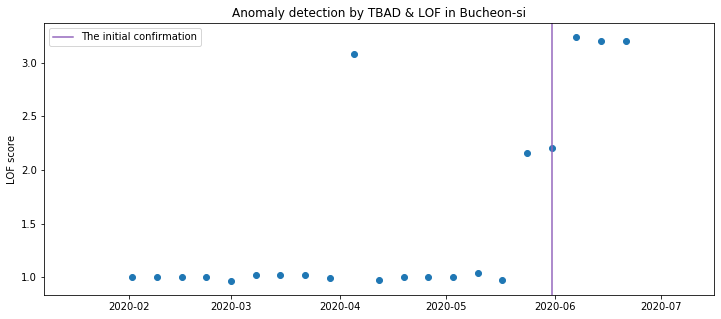

In [35]:
plt.figure(figsize=(12,5))
plt.scatter(xaxis,LOF_by_countries[47])
plt.axvline(xaxis[-4], color ='tab:purple', label="The initial confirmation")
plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[47]))
plt.show()


In [36]:
ABt = []
for Ai in Aopt_array:
    ABt.append(Ai.dot(Bstar.T))
ABt = np.array(ABt)

In [37]:
regularized_adj = np.mean(ABt, axis=0)
raw_adj = np.mean(travel_data[:,:,:54], axis=0)

In [38]:
incoming = np.sum(regularized_adj[:,:54], axis=0)
outgoing = np.sum(regularized_adj[:,54:], axis=0)
raw_incoming = np.sum(raw_adj, axis=0)
raw_outcoming = np.sum(raw_adj, axis=1)

In [39]:
def normalize(data):
#     a = data - np.min(data)
#     return a/(np.max(data)-np.min(data))
    return data/np.std(data)

In [40]:
net_traffic = normalize(incoming - outgoing)
net_traffic_raw = normalize(raw_incoming - raw_outcoming)

In [41]:
# incom_df = pd.DataFrame([label_dict[0],incoming[0]]).T
# outgo_df = pd.DataFrame([label_dict[0],outgoing[0]]).T
net_traffic_df = pd.DataFrame([label_dict[0],net_traffic[0]]).T
raw_net_traffic_df = pd.DataFrame([label_dict[0],net_traffic_raw[0]]).T
for node in range(1,54):
    d1 = [label_dict[node],net_traffic[node]]
    d2 = [label_dict[node],net_traffic_raw[node]]
    net_traffic_df = net_traffic_df.append(pd.Series(d1, index=net_traffic_df.columns),ignore_index=True)
    raw_net_traffic_df = raw_net_traffic_df.append(pd.Series(d2, index=raw_net_traffic_df.columns),ignore_index=True)
#     incom_df= incom_df.append(pd.Series([label_dict[node],incoming[node]], index=incom_df.columns),ignore_index=True)
#     outgo_df= outgo_df.append(pd.Series([label_dict[node],outgoing[node]], index=outgo_df.columns),ignore_index=True)

In [42]:
import folium
m = folium.Map(
    location=[37.5838699,126.9065831],
    zoom_start=11,
    tiles='Stamen Toner'
)

import json
geo_path = '../SocialGeo_measures/seoul_municipalities_geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

folium.Choropleth(geo_data=geo_str, 
                  data=net_traffic_df, 
                  columns=net_traffic_df.columns, 
                  fill_color='RdYlGn',
                  fill_opacity=1,
                  line_opacity=0.5,
                  key_on='properties.SIG_ENG_NM').add_to(m)

m

In [43]:
import folium
m = folium.Map(
    location=[37.5838699,126.9065831],
    zoom_start=11,
    tiles='Stamen Toner'
)

import json
geo_path = '../SocialGeo_measures/seoul_municipalities_geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

folium.Choropleth(geo_data=geo_str, 
                  data=raw_net_traffic_df, 
                  columns=raw_net_traffic_df.columns, 
                  fill_color='RdYlGn',
                  fill_opacity=1,
                  line_opacity=0.5,
                  key_on='properties.SIG_ENG_NM').add_to(m)

m

In [44]:
# travel_data.shape
tensors = travel_data
time = 5
intraffic = np.sum(tensors[time,:,:54], 0) #in-traffic
outtraffic = np.sum(tensors[time,:,:54], 1) #outtraffic
total_traffic = intraffic + outtraffic
total_traffic

intraffic = np.sum(tensors[time-1,:,:54], 0) #in-traffic
outtraffic = np.sum(tensors[time-1,:,:54], 1) #outtraffic
total_traffic2 = intraffic + outtraffic
total_traffic = total_traffic-total_traffic2

In [45]:
total_traffic_df = pd.DataFrame([label_dict[0],total_traffic[0]]).T
for node in range(1,54):
    d1 = [label_dict[node],total_traffic[node]]
    total_traffic_df = total_traffic_df.append(pd.Series(d1, index=total_traffic_df.columns),ignore_index=True)

total_traffic_df.columns=['SIG_ENG_NM','traffic']

In [46]:
import folium
m = folium.Map(
    location=[37.5838699,126.9065831],
    zoom_start=11,
    tiles='Stamen Toner'
)

import json
geo_path = '../SocialGeo_measures/seoul_municipalities_geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

folium.Choropleth(geo_data=geo_str, 
                  data=total_traffic_df, 
                  columns=total_traffic_df.columns, 
                  fill_color='YlOrRd',
                  fill_opacity=1,
                  line_opacity=0.5,
                  threshold_scale=np.linspace(-15, 60.0, num=10),
                  key_on='properties.SIG_ENG_NM').add_to(m)

m